### OCT Analysis - Pipe Line


In [1]:
# 1) Install and import dependencies
import os, sys
# Attempt imports; install missing packages on the fly
required = ["torch", "torchvision", "datasets", "timm", "gdown", "sklearn", "pandas", "matplotlib", "seaborn", "tqdm"]
for pkg in required:
    try:
        __import__(pkg)
    except ImportError:
        os.system(f"{sys.executable} -m pip install --quiet {pkg}")

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from datasets import load_dataset, config
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

print("✅ All dependencies imported")

✅ All dependencies imported


In [2]:
# 2) Clone RETFound_MAE and download pretrained OCT weights
REPO = "RETFound_MAE"
if not os.path.isdir(REPO):
    print(f"Cloning RETFound_MAE into {REPO}...")
    os.system(f"git clone https://huggingface.co/open-eye/RETFound_MAE {REPO}")
sys.path.append(os.path.join(os.getcwd(), REPO))

WEIGHTS = "RETFound_oct_weights.pth"
if not os.path.isfile(WEIGHTS):
    print(f"Downloading OCT pretrained weights to {WEIGHTS}...")
    os.system("gdown --quiet --id 1m6s7QYkjyjJDlpEuXm7Xp3PmjN-elfW2 -O " + WEIGHTS)
else:
    print(f"Pretrained weights already exist: {WEIGHTS}")

Pretrained weights already exist: RETFound_oct_weights.pth


In [3]:
# 3) Load and prepare the model
import models_vit
from util.pos_embed import interpolate_pos_embed
from timm.layers import trunc_normal_

# Load checkpoint
checkpoint = torch.load(WEIGHTS, map_location='cpu', weights_only=False)
ckpt_model = checkpoint['model']

# Instantiate ViT with appropriate number of classes
num_classes = 4  # CNV, DME, Drusen, Normal
print(f"→ Fine‑tuning for {num_classes} OCT classes")
model = models_vit.__dict__['vit_large_patch16'](
    num_classes=num_classes,
    drop_path_rate=0.2,
)
# Prune mismatched head weights
state = model.state_dict()
for k in ('head.weight','head.bias'):
    if k in ckpt_model and ckpt_model[k].shape != state[k].shape:
        del ckpt_model[k]
# Interpolate position embeddings and load weights
interpolate_pos_embed(model, ckpt_model)
msg = model.load_state_dict(ckpt_model, strict=False)
print("Loaded pretrained weights; missing keys:", msg.missing_keys)
if 'head.weight' in msg.missing_keys:
    trunc_normal_(model.head.weight, std=2e-5)
model.eval()
print("✅ Model is ready")

→ Fine‑tuning for 4 OCT classes
Loaded pretrained weights; missing keys: ['head.weight', 'head.bias']
✅ Model is ready


In [4]:
# 4) Load, split, and prepare the OCT2017 dataset
print("HF_DATASETS_CACHE:", config.HF_DATASETS_CACHE)
try:
    raw_ds = load_dataset("MaybeRichard/OCT-retina-classification-2017", split="train")
    print(f"Loaded OCT with {len(raw_ds)} samples")
except Exception as e:
    raise RuntimeError("Failed to load OCT2017 dataset: " + str(e))

# 80/20 train/val split
total = len(raw_ds)
val_size = int(total * 0.2)
train_size = total - val_size
train_ds, val_ds = random_split(raw_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))
print(f"Split data into {len(train_ds)} train and {len(val_ds)} val samples")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# PyTorch Dataset wrapper
target_names = ['CNV','DME','Drusen','Normal']
class OCTDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        ex = self.subset[idx]
        img = ex['image']
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(ex['label'])
        return img, label

# Create DataLoaders with progress feedback
train_loader = DataLoader(OCTDataset(train_ds, transform), batch_size=16, shuffle=True, num_workers=4)
val_loader   = DataLoader(OCTDataset(val_ds,   transform), batch_size=16, shuffle=False, num_workers=4)
print("✅ DataLoaders ready")

HF_DATASETS_CACHE: /home/zeus/.cache/huggingface/datasets


README.md:   0%|          | 0.00/433 [00:00<?, ?B/s]

train-00000-of-00008.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

train-00001-of-00008.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

train-00002-of-00008.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00003-of-00008.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

train-00004-of-00008.parquet:   0%|          | 0.00/417M [00:00<?, ?B/s]

train-00005-of-00008.parquet:   0%|          | 0.00/410M [00:00<?, ?B/s]

train-00006-of-00008.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

train-00007-of-00008.parquet:   0%|          | 0.00/421M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43878 [00:00<?, ? examples/s]

Loaded OCT with 43878 samples
Split data into 35103 train and 8775 val samples
✅ DataLoaders ready


In [5]:
# 5) Training & validation loop with tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-4)
epochs = 5
train_losses, val_accs = [], []

for ep in range(1, epochs+1):
    # Training
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(train_loader, desc=f"Train Epoch {ep}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {ep} — Train Loss: {avg_loss:.4f}")
    
    # Validation
    model.eval()
    correct = total = 0
    for imgs, labels in tqdm(val_loader, desc=f"Val Epoch {ep}/{epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = correct / total
    val_accs.append(acc)
    print(f"Epoch {ep} — Val Acc: {acc:.4%}")

Train Epoch 1/5:   0%|          | 0/2194 [00:00<?, ?it/s]

Epoch 1 — Train Loss: 0.2449


Val Epoch 1/5:   0%|          | 0/549 [00:00<?, ?it/s]

Epoch 1 — Val Acc: 95.6467%


Train Epoch 2/5:   0%|          | 0/2194 [00:00<?, ?it/s]

Epoch 2 — Train Loss: 0.1111


Val Epoch 2/5:   0%|          | 0/549 [00:00<?, ?it/s]

Epoch 2 — Val Acc: 95.8860%


Train Epoch 3/5:   0%|          | 0/2194 [00:00<?, ?it/s]

Epoch 3 — Train Loss: 0.0875


Val Epoch 3/5:   0%|          | 0/549 [00:00<?, ?it/s]

Epoch 3 — Val Acc: 96.1481%


Train Epoch 4/5:   0%|          | 0/2194 [00:00<?, ?it/s]

Epoch 4 — Train Loss: 0.0716


Val Epoch 4/5:   0%|          | 0/549 [00:00<?, ?it/s]

Epoch 4 — Val Acc: 95.7151%


Train Epoch 5/5:   0%|          | 0/2194 [00:00<?, ?it/s]

Epoch 5 — Train Loss: 0.0627


Val Epoch 5/5:   0%|          | 0/549 [00:00<?, ?it/s]

Epoch 5 — Val Acc: 94.1425%


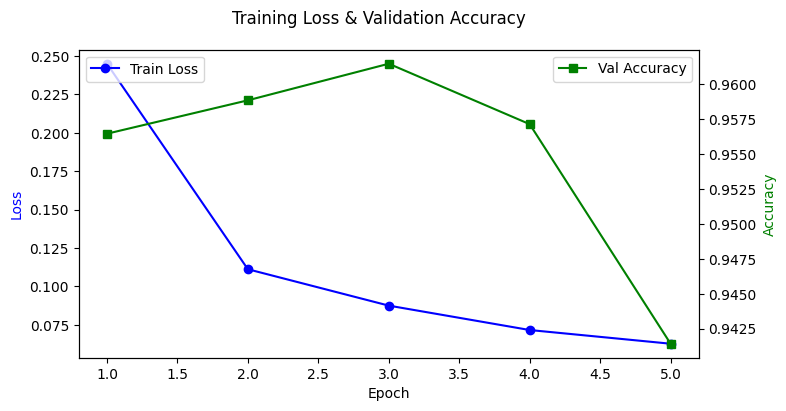

In [6]:
# 6) Plot learning curves
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(range(1, epochs+1), train_losses, 'b-o', label='Train Loss')
ax2 = ax1.twinx()
ax2.plot(range(1, epochs+1), val_accs, 'g-s', label='Val Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax2.set_ylabel('Accuracy', color='g')
fig.suptitle('Training Loss & Validation Accuracy')
ax1.legend(loc='upper left'); ax2.legend(loc='upper right')
plt.show()

Classification Report:
              precision    recall  f1-score   support

         CNV       0.99      0.92      0.95      3857
         DME       0.96      0.92      0.94      1159
      Drusen       0.73      0.92      0.82       912
      Normal       0.96      0.98      0.97      2847

    accuracy                           0.94      8775
   macro avg       0.91      0.94      0.92      8775
weighted avg       0.95      0.94      0.94      8775



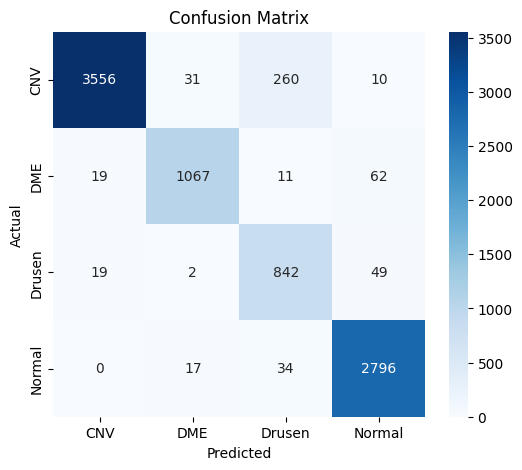

In [7]:
# 7) Confusion matrix & classification report
all_preds, all_labels = [], []
model.eval()
for imgs, labels in val_loader:
    imgs = imgs.to(device)
    preds = model(imgs).argmax(dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

In [8]:
# 8) Save metrics to CSV
results = pd.DataFrame({
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_accuracy': val_accs
})
ts = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
outfile = f"oct_metrics_{ts}.csv"
results.to_csv(outfile, index=False)
print(f"Saved metrics to {outfile}")

Saved metrics to oct_metrics_20250420_115758.csv


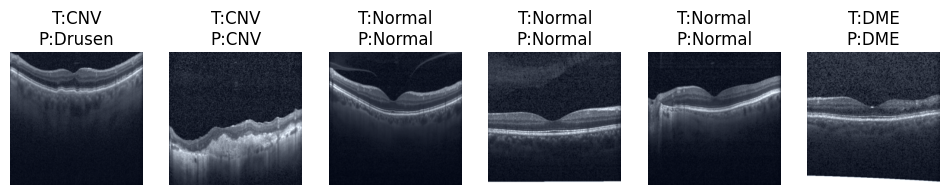

In [10]:
# 9) Sample inference visualization
def show_samples(n=6):
    imgs, labels = next(iter(val_loader))
    imgs, labels = imgs[:n], labels[:n]
    preds = model(imgs.to(device)).argmax(dim=1).cpu()
    imgs = imgs.permute(0,2,3,1).numpy()
    fig, axs = plt.subplots(1, n, figsize=(12,3))
    for i, ax in enumerate(axs):
        ax.imshow((imgs[i]*0.229+0.485).clip(0,1))
        ax.set_title(f"T:{target_names[labels[i]]}\nP:{target_names[preds[i]]}")
        ax.axis('off')
    plt.show()

show_samples()

End of OCT Analysis
----------------------------------
This notebook provides a clear, step-by-step analysis pipeline
including robust checks, progress bars, metrics logging, and visualizations.